In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import auc


In [11]:
prob = "LunarLander"
window_size = 10
nb_episodes = 300


In [12]:
def compute_auc_and_std(data, nb_episodes):
    # data = np.load(filepath, allow_pickle=True)
    all_returns = data['episode_rewards']  # shape: (n_seeds, n_episodes)
    # print("all_returns ", all_returns, "\n")
    
    # print("all_returns shape:", all_returns.shape, "\n")
    aucs = []
    for rewards in all_returns:
        returns = rewards[:nb_episodes]
        x = np.arange(len(returns))
        aucs.append(auc(x, returns))

    auc_mean = np.mean(aucs)
    auc_std = np.std(aucs)
    return auc_mean, auc_std


In [13]:
base_path = f"C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\Results\\{prob}"



### Lower y-position for goal


In [14]:
import gymnasium as gym
from Files.choose_action import choose_action_func
from Files.state_pred_models import NextStateQuantileNetwork, quantile_loss, NextStateSinglePredNetwork, quantile_loss_median, mse_loss
from Files.setup import setup_class
prob_vars = setup_class(prob)
model = NextStateQuantileNetwork(prob_vars.state_dim, prob_vars.action_dim, prob_vars.num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


ModuleNotFoundError: No module named 'mpc'

In [ ]:
# Reload model parameters and optimizer state
checkpoint = torch.load('C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\saved_model_LunarLander.pth')
model.load_state_dict(checkpoint['model_QRNN_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_QRNN_state_dict'])

# After loading, switch model to evaluation mode
model.eval()


NextStateQuantileNetwork(
  (layer1): Linear(in_features=9, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=88, bias=True)
)

In [ ]:
env = gym.make("Pendulum-v1", render_mode="human")
seed = 0
do_RS = False
do_QRNN_step_rnd = False
use_sampling = False
use_mid = True
use_ASGNN = None
model_QRNN = None
model_ASN = None

In [ ]:
for episode in range(1):
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        done = False
        actions_list = []
        if prob_vars.prob == "Pendulum":
            state = env.state.copy()
        if prob_vars.prob == "PandaReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "PandaReacherDense":
            prob_vars.goal_state = state['desired_goal'] # 3 components
            state = state['observation']#[:3] # 6 components for Reacher, 18 components for Pusher
        if prob_vars.prob == "MuJoCoReacher":
            prob_vars.goal_state = np.array([state[4], state[5]])
            state = np.array([state[0], state[1], state[2], state[3], state[6], state[7], state[8], state[9]])
        if prob_vars.prob == "MuJoCoPusher":
            prob_vars.goal_state = np.array([state[20], state[21], state[22]])
            
        
        costs = []
        episodic_step_rewards = []
        episodic_step_reward_values = []
        
        # if episode == 0:
        #     # Random initial action sequence
        #     # initial_action_sequence = np.random.randint(0, 2, horizon)
        #     init_particles = [np.random.uniform(-2, 2, horizon) for _ in range(num_particles)] # 2*horizon_list[0]
        # else:
        #     # Add small random noise to encourage exploration (for now this can stay the same)
        #     # particles = np.clip(best_action_sequence + np.random.randint(0, 2, horizon), 0, 1)
        #     for i in range(len(particles)):
        #         # print("best_particle ", best_particle, "\n")
        #         # print("np.random.uniform(-0.5, 0.5, horizon) ", np.random.uniform(-0.5, 0.5, horizon), "\n")
        #         particles[i] = np.clip(best_particle + np.random.uniform(-0.5, 0.5, horizon), -2, 2)
        #         # particles = np.clip(init_particles + np.random.randint(0, 2, len(init_particles)), 0, 1)
        
        # particles = [np.random.uniform(-2, 2, horizon) for _ in range(num_particles)] # 2*horizon_list[0]
        
        if prob_vars.prob == "CartPole":
            particles = np.random.randint(0, 2, (prob_vars.num_particles, prob_vars.horizon))
        elif prob_vars.prob == "Acrobot" or prob_vars.prob == "MountainCar": 
            particles = np.random.randint(0, 3, (prob_vars.num_particles, prob_vars.horizon))
        elif prob_vars.prob == "LunarLander":
            particles = np.random.randint(0, 4, (prob_vars.num_particles, prob_vars.horizon))
        elif prob_vars.prob == "PandaReacher" or prob_vars.prob == "MuJoCoReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "MuJoCoPusher" or prob_vars.prob == "LunarLanderContinuous" or prob_vars.prob == "PandaReacherDense":
            particles = np.random.uniform(prob_vars.action_low, prob_vars.action_high, (prob_vars.num_particles, prob_vars.action_dim*prob_vars.horizon))
        else: # Pendulum, MountainCarContinuous
            particles = np.random.uniform(prob_vars.action_low, prob_vars.action_high, (prob_vars.num_particles, prob_vars.horizon))
        
        # particles = np.zeros((num_particles, horizon))
        # particles[0] = np.array([-1.982811505902002, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, -1.0812550657808897, 2.0, 2.0, 2.0, 0.6938272212396055, 2.0])
        
        # for step in range(tqdm(max_steps)):
        for step in range(prob_vars.max_steps):
            # Get the current state
            # """ Need to change this!!!!!!!!!!!!!!!!! """
            # state = env.state
            # print("step ", step, "\n")
            if prob_vars.prob == "Pendulum":
                state = env.state.copy()
            
            # Choose the best action sequence
            # if step == 0:
            #     best_particle, particles, cost = particle_filtering_cheating(init_particles, env, state, horizon, nb_reps=5, using_Env=usingEnv, episode=episode, step=step)
            # elif step >= 1:
            #     best_particle, particles, cost = particle_filtering_cheating(particles, env, state, horizon, nb_reps=5, using_Env=usingEnv, episode=episode, step=step)
            
            # particles = np.random.uniform(-2, 2, (num_particles, horizon))
            
            # print("state ", state, "\n")
            
            # print("len(particles) ", len(particles), "\n")
            
            if do_RS or do_QRNN_step_rnd:
                if prob_vars.prob == "CartPole":
                    particles = np.random.randint(0, 2, (prob_vars.num_particles, prob_vars.horizon))
                elif prob_vars.prob == "Acrobot" or prob_vars.prob == "MountainCar":
                    particles = np.random.randint(0, 3, (prob_vars.num_particles, prob_vars.horizon))
                elif prob_vars.prob == "LunarLander":
                    particles = np.random.randint(0, 4, (prob_vars.num_particles, prob_vars.horizon))
                elif prob_vars.prob == "PandaReacher" or prob_vars.prob == "MuJoCoReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "MuJoCoPusher" or prob_vars.prob == "LunarLanderContinuous" or prob_vars.prob == "PandaReacherDense":
                    particles = np.random.uniform(prob_vars.action_low, prob_vars.action_high, (prob_vars.num_particles, prob_vars.action_dim*prob_vars.horizon))
                else: # Pendulum, MountainCarContinuous
                    particles = np.random.uniform(prob_vars.action_low, prob_vars.action_high, (prob_vars.num_particles, prob_vars.horizon))
            # best_particle, action, best_cost, particles = choose_action(prob, state, do_RS, use_sampling, use_mid, use_ASGNN, horizon, particles, model_QRNN, action_low, action_high, nb_reps_MPC, std, change_prob, nb_top_particles, nb_random, episode=episode, step=step, goal_state=goal_state)
            ##

            particles = np.clip(particles, prob_vars.action_low, prob_vars.action_high)

            best_particle, action, best_cost, particles = choose_action_func(prob_vars, state, particles, do_RS, use_sampling, use_mid, use_ASGNN, model_QRNN, model_ASN, episode=episode, step=step, goal_state=prob_vars.goal_state)
            # best_particle, action, best_cost, particles = choose_action(prob_vars.prob, state, horizon, particles, do_RS, use_sampling, use_mid, use_ASGNN, model_QRNN, model_ASN, action_dim, action_low, action_high, states_low, states_high, nb_reps_MPC, std, change_prob, nb_top_particles, nb_random, episode=episode, step=step, goal_state=goal_state)
            
            # best_particle, particles, cost = particle_filtering_cheating(particles, env, state, horizon, nb_reps=5, using_Env=usingEnv, episode=episode, step=step)
            
            # print("action ", action, "\n")
            
            # print("best_particle ", best_particle, "\n")
            # if prob != "CartPole" and prob != "Acrobot" and prob != "PandaReacher" and prob != "MuJoCoReacher":
            #     action = [best_particle[0]]
            
            actions_list.append(action)
            
            costs.append(best_cost)
            
            if prob_vars.prob == "Pendulum" or prob_vars.prob == "MountainCarContinuous" or prob_vars.prob == "Pendulum_xyomega" or prob_vars.prob == "InvertedPendulum":
                action = [best_particle[0]]
                # print("action ", action, "\n")
            
            elif prob_vars.prob == "PanadaReacher" or prob_vars.prob == "MuJoCoReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "MuJoCoPusher" or prob_vars.prob == "LunarLanderContinuous" or prob_vars.prob == "PandaReacherDense":
                action = best_particle[:prob_vars.action_dim]
            
            elif prob_vars.prob == "CartPole" or prob_vars.prob == "Acrobot" or prob_vars.prob == "MountainCar" or prob_vars.prob == "LunarLander":
                action = int(action)
            
            # if prob == "CartPole" or prob == "Acrobot":
            #     action = int(action)
            
            # Apply the first action from the optimized sequence
            next_state, reward, done, truncated, info = env.step(action)
            
            episode_reward += reward
            actions_list.append(action)
            
            # Apply the first action from the optimized sequence
            # next_state, reward, done, terminated, info = env.step(action)
            # episode_reward += reward
            if prob_vars.prob == "Pendulum":
                # state = env.state.copy()
                next_state = env.state.copy()
            if prob_vars.prob == "PandaReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "PandaReacherDense":
                prob_vars.goal_state = next_state['desired_goal'] # 3 components
                next_state = next_state['observation']#[:3] # 6 components
            if prob_vars.prob == "MuJoCoReacher":
                next_state = np.array([next_state[0], next_state[1], next_state[2], next_state[3], next_state[6], next_state[7], next_state[8], next_state[9]])
                
            # print("state ", state, "next_state ", next_state, "\n")
            # print("states[0] ", state[0], "states[1] ", state[1], "\n")
            
            # episodic_step_rewards.append(episode_reward)
            # episodic_step_reward_values.append(reward)
            
            # next_state = env.state.copy()
            # Store experience in replay buffer
            # print("state ", state, "\n")
            
            # if prob != "CartPole" and prob != "Acrobot":
            #     replay_buffer.append((state, action, reward, next_state, done))
            # else:
            #     replay_buffer.append((state, np.array([action]), reward, next_state, terminated))
            # if prob_vars.prob == "CartPole" or prob_vars.prob == "Acrobot" or prob_vars.prob == "MountainCar" or prob_vars.prob == "LunarLander":
            #     replay_buffer_QRNN.append((state, np.array([action]), reward, next_state, truncated))
            # else:
            #     replay_buffer_QRNN.append((state, action, reward, next_state, truncated))
            
                
            # if len(replay_buffer_QRNN) < prob_vars.batch_size:
            #     pass
            # else:
            #     batch = random.sample(replay_buffer_QRNN, prob_vars.batch_size)
            #     states, actions_train, rewards, next_states, dones = zip(*batch)
            #     # print("batch states ", states, "\n")
            #     states = torch.tensor(states, dtype=torch.float32)
            #     actions_tensor = torch.tensor(actions_train, dtype=torch.float32)
            #     # print("actions.shape ", actions_tensor, "\n")
            #     rewards = torch.tensor(rewards, dtype=torch.float32)
            #     next_states = torch.tensor(next_states, dtype=torch.float32)
            #     dones = torch.tensor(dones, dtype=torch.float32)

            #     # if prob == "PandaReacher" or prob == "PandaPusher" or prob == "MuJoCoReacher":
            #     #     # Clip states to ensure they are within the valid range
            #     #     # before inputting them to the model (sorta like normalization)
            #     states = torch.clip(states, prob_vars.states_low, prob_vars.states_high)
            #     # states = 2 * ((states - prob_vars.states_low) / (prob_vars.states_high - prob_vars.states_low)) - 1
            #     actions_tensor = torch.clip(actions_tensor, prob_vars.action_low, prob_vars.action_high)
                
            #     # Predict next state quantiles
            #     predicted_quantiles = model_QRNN(states, actions_tensor)  # Shape: (batch_size, num_quantiles, state_dim)
                
            #     # Use next state as target (can be improved with target policy)
            #     target_quantiles = next_states
                
            #     # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
            #     # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

            #     # Compute Quantile Huber Loss
            #     loss = quantile_loss(predicted_quantiles, target_quantiles, prob_vars.quantiles)
                
            #     # # Compute Quantile Huber Loss
            #     # loss = quantile_loss(predicted_quantiles, target_quantiles, quantiles)
                
            #     # Optimize the model
            #     optimizer_QRNN.zero_grad()
            #     loss.backward()
            #     optimizer_QRNN.step()
            
            # if prob == "MuJoCoReacher":
            #     if np.sqrt(next_state[-2]**2+next_state[-1]**2) < 0.05:
            #         print("Reached target position \n")
            #         done = True
            
            done = done or truncated
            if done:
                nb_episode_success += 1
                break
            
            if not do_RS or not do_QRNN_step_rnd:
                if prob_vars.prob == "CartPole":
                    # Shift all particles to the left by removing the first element
                    particles[:, :-1] = particles[:, 1:]
                
                    # Generate new random values (0 or 1) for the last column
                    new_values = np.random.randint(0, 2, size=(particles.shape[0], 1))
                    
                    # Add the new values to the last position
                    particles[:, -1:] = new_values
                    
                elif prob_vars.prob == "Acrobot" or prob_vars.prob == "MountainCar":
                    # Shift all particles to the left by removing the first element
                    particles[:, :-1] = particles[:, 1:]
                    
                    # Generate new random values (0 or 1) for the last column
                    new_values = np.random.randint(0, 3, size=(particles.shape[0], 1))
                    
                    # Add the new values to the last position
                    particles[:, -1:] = new_values

                elif prob_vars.prob == "LunarLander":
                    # Shift all particles to the left by removing the first element
                    particles[:, :-1] = particles[:, 1:]
                    
                    # Generate new random values (0 or 1) for the last column
                    new_values = np.random.randint(0, 4, size=(particles.shape[0], 1))
                    
                    # Add the new values to the last position
                    particles[:, -1:] = new_values
                
                elif prob_vars.prob == "PandaReacher" or prob_vars.prob == "MuJoCoReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "MuJoCoPusher" or prob_vars.prob == "LunarLanderContinuous" or prob_vars.prob == "PandaReacherDense":
                    # Shift all particles to the left by removing the first element
                    particles[:, :-prob_vars.action_dim] = particles[:, prob_vars.action_dim:]
                    
                    # Generate new random values for the last column
                    new_values = np.random.uniform(prob_vars.action_low, prob_vars.action_high, size=(particles.shape[0], prob_vars.action_dim))
                    
                    # Add the new values to the last position
                    particles[:, -prob_vars.action_dim:] = new_values  
                
                else: # Pendulum, MountainCarContinuous, Pendulum_xyomega
                    # Shift all particles to the left by removing the first element
                    particles[:, :-1] = particles[:, 1:]
                    
                    # Generate new random values for the last column
                    new_values = np.random.uniform(prob_vars.action_low, prob_vars.action_high, size=(particles.shape[0], 1))
                    
                    # Add the new values to the last position
                    particles[:, -1:] = new_values
            particles = np.clip(particles, prob_vars.action_low, prob_vars.action_high)
            
            # if step == 0:
            #     # print("len(init_particles) ", len(init_particles), "\n")
            #     # particles = np.copy(init_particles)
            #     for i in range(len(particles)):
            #         # particles[i] = np.clip(top_particles[0][1:] + [np.random.randint(0, 2)], 0, 1)
            #         particles[i] = np.clip(np.append(particles[i][1:],[np.random.uniform(-2, 2)]), -2, 2)
            #         # print("particles[i] ", particles[i].shape, "\n")    
            # else:
            #     # print("len(particles) ", len(particles), "\n")
            #     particles[0] = best_particle
            #     for i in range(1, len(particles)):
            #         # particles[i] = np.clip(top_particles[0][1:] + [np.random.randint(0, 2)], 0, 1)
            #         particles[i] = np.clip(np.append(particles[i][1:],[np.random.uniform(-2, 2)]), -2, 2)
            #         # print("particles[i] ", particles[i].shape, "\n")
            
            # state = env.state.copy() # next_state
            
            state = next_state
        
        # print("best_particle ", best_particle, "\n")
        # print("actions ", actions, "\n")
        # print('horizon: %d, episode: %d, reward: %d' % (horizon, episode, episode_reward))
        # episode_reward_list.append(episode_reward)

        # episode_success_rate.append(nb_episode_success/(episode+1)) # Episodic success rate for Panda Gym envs
        # episode_success_rate.append(nb_episode_success) # /max_steps # Episodic success rate for Panda Gym envs     
        
        # print("actions_list ", actions_list, "\n")
        
        # print(f'episode: {episode}, reward: {episode_reward}')
        # # episode_reward_list.append(episode_reward)
        # print("actions_list ", actions_list, "\n")
        
        ''' Print stuff '''
        # if prob == 'PandaReacher':
        #     print("np.linalg.norm(goal_state-state) ", np.linalg.norm(goal_state-next_state[:3]), "\n")
        #     print("actions_list ", actions_list, "\n")
        # if prob == "MuJoCoReacher":
        #     print("np.linalg.norm(goal_state-state)=np.sqrt(next_state[-2]**2+next_state[-1]**2) ", np.sqrt(next_state[-2]**2+next_state[-1]**2), "\n")

    # if use_sampling:
    #     if do_RS:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"RS_{prob_vars.prob}_sampling_{prob_vars.change_prob}.pth")
    #     elif do_QRNN_step_rnd:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"QRNN_step_rnd_{prob_vars.prob}_sampling_{prob_vars.change_prob}.pth")
    #     else:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"QRNN_basic_{prob_vars.prob}_sampling_{prob_vars.change_prob}.pth")
    # if use_mid:
    #     if do_RS:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"RS_{prob_vars.prob}_mid_{prob_vars.change_prob}.pth")
    #     elif do_QRNN_step_rnd:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"QRNN_step_rnd_{prob_vars.prob}_mid_{prob_vars.change_prob}.pth")
    #     else:
    #         # Assuming `agent` is your RL model and `optimizer` is the optimizer
    #         torch.save({
    #             'model_state_dict': model_QRNN.state_dict(),
    #             'optimizer_state_dict': optimizer_QRNN.state_dict(),
    #         }, f"QRNN_basic_{prob_vars.prob}_mid_{prob_vars.change_prob}.pth")
    
    
    # # Save model parameters and optimizer state
    # torch.save({
    #     'model_QRNN_state_dict': model_QRNN.state_dict(),
    #     'optimizer_QRNN_state_dict': optimizer_QRNN.state_dict(),
    # }, f'saved_model_{prob_vars.prob}.pth')
    
    # # return episode_reward_list
    # if prob_vars.prob == "PandaReacher" or prob_vars.prob == "PandaPusher" or prob_vars.prob == "MuJoCoReacher" or prob_vars.prob == "MuJoCoPusher" or prob_vars.prob == "PandaReacherDense":
    #     return episode_reward_list, episode_success_rate
    # else:
    #     return episode_reward_list
    

NameError: name 'choose_action_func' is not defined

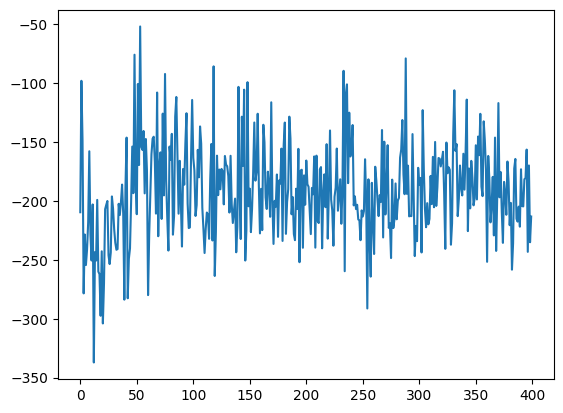

In [ ]:
plt.plot(np.load("C:\\Users\\nicle\\Desktop\\QRNN-MPC\\Files\\LunarLander_MPC_QRNN_basic_mid_LowerYGoal_May6.npz")['mean_rewards'])


### Graph


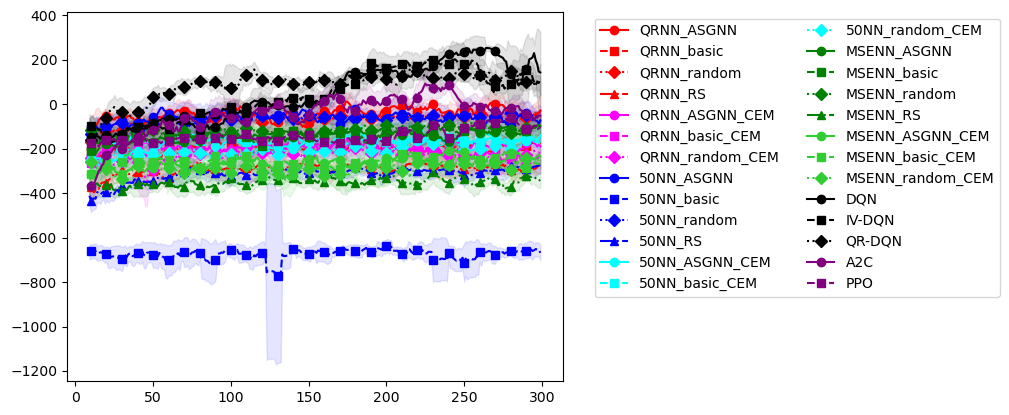

In [ ]:
QRNN = {'QRNN-ASGNN-PF': f'{base_path}\\{prob}_MPC_QRNN_ASGNN_mid_May6.npz',
    'QRNN-basic-PF': f'{base_path}\\{prob}_MPC_QRNN_basic_mid_May6.npz',
    'QRNN-random-PF': f'{base_path}\\{prob}_MPC_QRNN_random_mid_May6.npz',
    'QRNN-RS': f'{base_path}\\{prob}_RS_mid_QRNN_May6.npz',}
color = 'red'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

QRNN_CEM = {'QRNN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_QRNN_ASGNN_mid_May6_CEM.npz',
    'QRNN-basic-CEM': f'{base_path}\\{prob}_MPC_QRNN_basic_mid_May6_CEM.npz',
    'QRNN-random-CEM': f'{base_path}\\{prob}_MPC_QRNN_random_mid_May6_CEM.npz',}
color = 'magenta'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ####################################################
FiftyNN = {'50NN-ASGNN-PF': f'{base_path}\\{prob}_MPC_50NN_ASGNN_mid_May6.npz',
    '50NN-basic-PF': f'{base_path}\\{prob}_MPC_50NN_basic_mid_May6.npz',
    '50NN-random-PF': f'{base_path}\\{prob}_MPC_50NN_random_mid_May6.npz',
    '50NN-RS': f'{base_path}\\{prob}_RS_mid_50NN_May6.npz',}
color = 'blue'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

FiftyNN_CEM = {'50NN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_50NN_ASGNN_mid_May6_CEM.npz',
    '50NN-basic-CEM': f'{base_path}\\{prob}_MPC_50NN_basic_mid_May6_CEM.npz',
    '50NN-random-CEM': f'{base_path}\\{prob}_MPC_50NN_random_mid_May6_CEM.npz',}
color = 'aqua'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


# ####################################################
MSENN = {'MSENN-ASGNN-PF': f'{base_path}\\{prob}_MPC_MSENN_ASGNN_mid_May6.npz',
    'MSENN-basic-PF': f'{base_path}\\{prob}_MPC_MSENN_basic_mid_May6.npz',
    'MSENN-random-PF': f'{base_path}\\{prob}_MPC_MSENN_random_mid_May6.npz',
    'MSENN-RS': f'{base_path}\\{prob}_RS_mid_MSENN_May6.npz',}
color = 'green'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

MSENN_CEM = {'MSENN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_MSENN_ASGNN_mid_May6_CEM.npz',
    'MSENN-basic-CEM': f'{base_path}\\{prob}_MPC_MSENN_basic_mid_May6_CEM.npz',
    'MSENN-random-CEM': f'{base_path}\\{prob}_MPC_MSENN_random_mid_May6_CEM.npz',}
color = 'limegreen'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# ####################################################
# DQN_methods = {'DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DQN_results.npz',
#     'IV-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_IV_DQN_results.npz',
#     'QR-DQN': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_QR_DQN_results.npz',
#     }
DQN_methods = {'DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_DQN_results.npz',
    'IV-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_IV_DQN_results.npz',
    'QR-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_QR_DQN_results.npz',
    }

color = 'black'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in DQN_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


########################
RL_methods = {'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_A2C_results.npz',
    'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_PPO_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_DDPG_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_TQC_results.npz',
    
    # 'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
    # 'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
    }

color = 'purple'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', ' ', '', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in RL_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:300]
    std_rewards = data['std_rewards'][:300]

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    plt.plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    plt.fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)

# ########################
# RL_methods = {# 'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\CartPole_A2C_results.npz',
#     'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_A2C_results.npz',
#     'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_PPO_results.npz',
#     # # 'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\CartPole_PPO_results.npz',
#     # 'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
#     # # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
#     # 'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
#     # # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
#     # # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
#     # # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
#     }

# A2C_data = np.load(RL_methods['A2C'])
# mean_returns_A2C = A2C_data['mean_rewards'][:300]
# std_returns_A2C = A2C_data['std_rewards'][:300]
# # Smooth the data
# smoothed_mean_A2C = pd.Series(mean_returns_A2C).rolling(window=window_size).mean()
# smoothed_std_A2C = pd.Series(std_returns_A2C).rolling(window=window_size).std()

# PPO_data = np.load(RL_methods['PPO'])
# mean_returns_PPO = PPO_data['mean_rewards'][:300]
# std_returns_PPO = PPO_data['std_rewards'][:300]
# # Smooth the data
# smoothed_mean_PPO = pd.Series(mean_returns_PPO).rolling(window=window_size).mean()
# smoothed_std_PPO = pd.Series(std_returns_PPO).rolling(window=window_size).std()

# plt.plot(smoothed_mean_A2C, label='A2C', color='purple')
# plt.fill_between(range(len(smoothed_mean_A2C)), 
#                  smoothed_mean_A2C - smoothed_std_A2C, 
#                  smoothed_mean_A2C + smoothed_std_A2C, 
#                  color='purple', alpha=0.1)
# plt.plot(smoothed_mean_PPO, label='PPO', color='Olive')
# plt.fill_between(range(len(smoothed_mean_PPO)), 
#                  smoothed_mean_PPO - smoothed_std_PPO, 
#                  smoothed_mean_PPO + smoothed_std_PPO, 
#                  color='Olive', alpha=0.1)

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)


### Plot subfigures



QRNN_ASGNN: AUC = -13065.22 ± 4205.25
QRNN_basic: AUC = -58673.79 ± 26956.10
QRNN_random: AUC = -20620.00 ± 5954.58
QRNN_RS: AUC = -87354.92 ± 18649.91
50NN_ASGNN: AUC = -18611.58 ± 8012.68
50NN_basic: AUC = -201813.49 ± 36500.85
50NN_random: AUC = -19939.48 ± 5912.82
50NN_RS: AUC = -93949.03 ± 21756.79
MSENN_ASGNN: AUC = -42396.41 ± 14629.25
MSENN_basic: AUC = -40167.99 ± 16711.09
MSENN_random: AUC = -36118.32 ± 9498.36
MSENN_RS: AUC = -104688.69 ± 19505.39
############################################################# 

QRNN_ASGNN_CEM: AUC = -59162.79 ± 4233.73
QRNN_basic_CEM: AUC = -61975.98 ± 13693.30
QRNN_random_CEM: AUC = -68251.91 ± 11171.78
50NN_ASGNN_CEM: AUC = -52493.80 ± 2799.26
50NN_basic_CEM: AUC = -49145.88 ± 3277.66
50NN_random_CEM: AUC = -61049.32 ± 3064.96
MSENN_ASGNN_CEM: AUC = -78923.48 ± 11643.42
MSENN_basic_CEM: AUC = -78450.46 ± 12441.32
MSENN_random_CEM: AUC = -85238.75 ± 19606.39
############################################################# 

DQN: AUC = 13197.47 

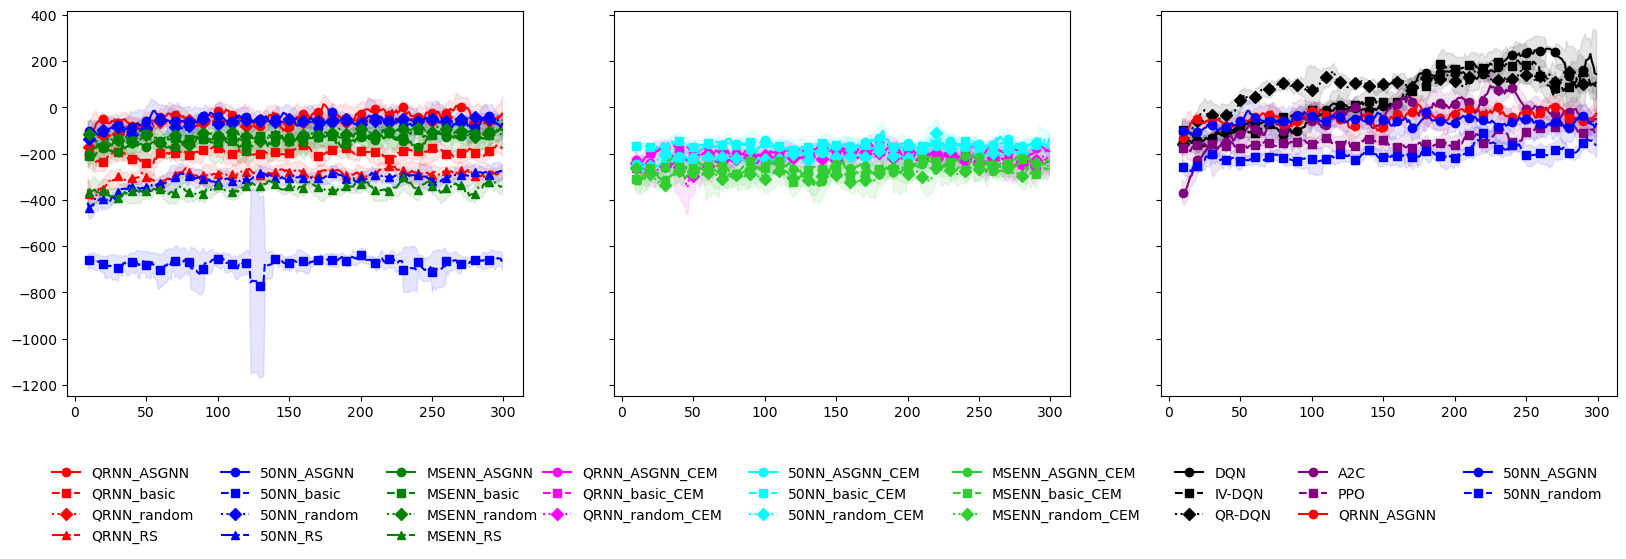

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20, 5), sharey=True)

QRNN = {'QRNN-ASGNN-PF': f'{base_path}\\{prob}_MPC_QRNN_ASGNN_mid_May6.npz',
    'QRNN-basic-PF': f'{base_path}\\{prob}_MPC_QRNN_basic_mid_May6.npz',
    'QRNN-random-PF': f'{base_path}\\{prob}_MPC_QRNN_random_mid_May6.npz',
    'QRNN-RS': f'{base_path}\\{prob}_RS_mid_QRNN_May6.npz',}
color = 'red'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[0].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[0].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

############################################################################

FiftyNN = {'50NN-ASGNN-PF': f'{base_path}\\{prob}_MPC_50NN_ASGNN_mid_May6.npz',
    '50NN-basic-PF': f'{base_path}\\{prob}_MPC_50NN_basic_mid_May6.npz',
    '50NN-random-PF': f'{base_path}\\{prob}_MPC_50NN_random_mid_May6.npz',
    '50NN-RS': f'{base_path}\\{prob}_RS_mid_50NN_May6.npz',}
color = 'blue'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[0].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[0].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

############################################################################

MSENN = {'MSENN-ASGNN-PF': f'{base_path}\\{prob}_MPC_MSENN_ASGNN_mid_May6.npz',
    'MSENN-basic-PF': f'{base_path}\\{prob}_MPC_MSENN_basic_mid_May6.npz',
    'MSENN-random_PF': f'{base_path}\\{prob}_MPC_MSENN_random_mid_May6.npz',
    'MSENN-RS': f'{base_path}\\{prob}_RS_mid_MSENN_May6.npz'}
color = 'green'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[0].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[0].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)

# from matplotlib.lines import Line2D

# custom_legend = [
#     Line2D([0], [0], color='red', lw=2, label='QRNN'),
#     Line2D([0], [0], color='blue', lw=2, label='50NN'),
#     Line2D([0], [0], color='green', lw=2, label='MSENN'),
#     Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=6, label='ASGNN'),
#     Line2D([0], [0], color='black', marker='s', linestyle='None', markersize=6, label='QRNN-CEM'),
#     Line2D([0], [0], color='black', marker='^', linestyle='None', markersize=6, label='50NN-CEM')
# ]

# axs[0].legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(0.5, -0.2),
#               ncol=3, fontsize=10, frameon=False)


###########################################################

print("############################################################# \n")

QRNN_CEM = {'QRNN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_QRNN_ASGNN_mid_May6_CEM.npz',
    'QRNN-basic-CEM': f'{base_path}\\{prob}_MPC_QRNN_basic_mid_May6_CEM.npz',
    'QRNN-random-CEM': f'{base_path}\\{prob}_MPC_QRNN_random_mid_May6_CEM.npz',}
color = 'magenta'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in QRNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[1].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[1].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

########################################################

FiftyNN_CEM = {'50NN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_50NN_ASGNN_mid_May6_CEM.npz',
    '50NN-basic-CEM': f'{base_path}\\{prob}_MPC_50NN_basic_mid_May6_CEM.npz',
    '50NN-random-CEM': f'{base_path}\\{prob}_MPC_50NN_random_mid_May6_CEM.npz',}
color = 'aqua'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in FiftyNN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[1].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[1].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


########################################################

MSENN_CEM = {'MSENN-ASGNN-CEM': f'{base_path}\\{prob}_MPC_MSENN_ASGNN_mid_May6_CEM.npz',
    'MSENN-basic-CEM': f'{base_path}\\{prob}_MPC_MSENN_basic_mid_May6_CEM.npz',
    'MSENN-random-CEM': f'{base_path}\\{prob}_MPC_MSENN_random_mid_May6_CEM.npz',}
color = 'limegreen'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in MSENN_CEM.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[1].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[1].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)

#############################################################

print("############################################################# \n")

DQN_methods = {'DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_DQN_results.npz',
    'IV-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_IV_DQN_results.npz',
    'QR-DQN': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_QR_DQN_results.npz',
    }

color = 'black'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in DQN_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    # print("mean_rewards ", data['ep[]'], "\n")
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[2].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[2].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

########################
########################
RL_methods = {'A2C': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_A2C_results.npz',
    'PPO': f'C:\\Users\\nicle\\Desktop\\QRNN-MPC\\sb3\\{prob}_PPO_results.npz',
    # 'A2C': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_A2C_results.npz',
    # 'DDPG': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_DDPG_results.npz',
    # 'PPO': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_PPO_results.npz',
    # 'SAC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_SAC_results.npz',
    # 'TD3': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TD3_results.npz',
    # 'TQC': f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Jan24\\April 4th tests\\QRNN-MPC-main\\QRNN-MPC-main\\Files\\{prob}_TQC_results.npz',
    }

color = 'purple'
# Assign markers and linestyles to sub-methods
markers = ['o', 's', 'D', '^', 'v', 'x', '*']  # Add more if needed
linestyles = ['-', '--', ':', '-.', ' ', '', (0, (3, 1, 1, 1))]  # Custom patterns
it = 0
for label, filepath in RL_methods.items():
    data = np.load(filepath)
    mean_rewards = data['mean_rewards'][:nb_episodes]
    std_rewards = data['std_rewards'][:nb_episodes]
    
    auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
    print(f"{label}: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

    # if it == 0:
    #     print(mean_rewards)
    #     print(std_rewards)
    
    # Smooth the data
    smoothed_mean = pd.Series(mean_rewards).rolling(window=window_size).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size).std()
    
    # Plot
    axs[2].plot(smoothed_mean, 
             label=f"{label}", 
             color=color,
             marker=markers[it],
             linestyle=linestyles[it],
             markevery=10)  # Show markers every 10 points
    
    # Confidence interval (optional)
    axs[2].fill_between(range(len(mean_rewards)), 
                     smoothed_mean - smoothed_std, 
                     smoothed_mean + smoothed_std, 
                     color=color, alpha=0.1)
    it += 1

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)


markers = ['o', 's', 'D', '^', 'v', 'x', '*']
linestyles = ['-', '--', ':', '-.', (0, (3, 1, 1, 1))]  # Custom patterns

# QRNN-ASGNN_PF
color_QRNN_ASGNN = 'red'
marker_QRNN_ASGNN = markers[0]
linestyle_QRNN_ASGNN = linestyles[0]
data = np.load(f'{base_path}\\{prob}_MPC_QRNN_ASGNN_mid_May6.npz')
mean_rewards_QRNN_ASGNN = data['mean_rewards'][:nb_episodes]
std_rewards_QRNN_ASGNN = data['std_rewards'][:nb_episodes]

auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
print(f"QRNN-ASGNN-PF: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

# Smooth the data
smoothed_mean_QRNN_ASGNN = pd.Series(mean_rewards_QRNN_ASGNN).rolling(window=window_size).mean()
smoothed_std_QRNN_ASGNN = pd.Series(std_rewards_QRNN_ASGNN).rolling(window=window_size).std()

# Plot
axs[2].plot(smoothed_mean_QRNN_ASGNN, 
            label='QRNN-ASGNN-PF', 
            color=color_QRNN_ASGNN,
            marker=marker_QRNN_ASGNN,
            linestyle=linestyle_QRNN_ASGNN,
            markevery=10)  # Show markers every 10 points

# Confidence interval (optional)
axs[2].fill_between(range(len(mean_rewards_QRNN_ASGNN)), 
                    smoothed_mean_QRNN_ASGNN - smoothed_std_QRNN_ASGNN, 
                    smoothed_mean_QRNN_ASGNN + smoothed_std_QRNN_ASGNN, 
                    color=color_QRNN_ASGNN, alpha=0.1)


# 50NN_ASGNN_PF
color_50NN_ASGNN = 'blue'
marker_50NN_ASGNN = markers[0]
linestyle_50NN_ASGNN = linestyles[0]
data = np.load(f'{base_path}\\{prob}_MPC_50NN_ASGNN_mid_May6.npz')
mean_rewards_50NN_ASGNN = data['mean_rewards'][:nb_episodes]
std_rewards_50NN_ASGNN = data['std_rewards'][:nb_episodes]

auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
print(f"50NN_ASGNN_PF: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

# Smooth the data
smoothed_mean_50NN_ASGNN = pd.Series(mean_rewards_50NN_ASGNN).rolling(window=window_size).mean()
smoothed_std_50NN_ASGNN = pd.Series(std_rewards_50NN_ASGNN).rolling(window=window_size).std()

# Plot
axs[2].plot(smoothed_mean_50NN_ASGNN, 
            label="50NN-ASGNN", 
            color=color_50NN_ASGNN,
            marker=marker_50NN_ASGNN,
            linestyle=linestyle_50NN_ASGNN,
            markevery=10)  # Show markers every 10 points

# Confidence interval (optional)
axs[2].fill_between(range(len(mean_rewards_50NN_ASGNN)), 
                    smoothed_mean_50NN_ASGNN - smoothed_std_50NN_ASGNN, 
                    smoothed_mean_50NN_ASGNN + smoothed_std_50NN_ASGNN, 
                    color=color_50NN_ASGNN, alpha=0.1)

# 50NN_random_PF
color_50NN_rnd = 'blue'
marker_50NN_rnd = markers[1]
linestyle_50NN_rnd = linestyles[1]
data = np.load(f'{base_path}\\{prob}_MPC_50NN_random_mid_May6_CEM.npz')
mean_rewards_50NN_rnd = data['mean_rewards'][:nb_episodes]
std_rewards_50NN_rnd = data['std_rewards'][:nb_episodes]

auc_mean, auc_std = compute_auc_and_std(data, nb_episodes)
print(f"50NN_random_PF: AUC = {auc_mean:.2f} ± {auc_std:.2f}")

# Smooth the data
smoothed_mean_50NN_rnd = pd.Series(mean_rewards_50NN_rnd).rolling(window=window_size).mean()
smoothed_std_50NN_rnd = pd.Series(std_rewards_50NN_rnd).rolling(window=window_size).std()

# Plot
axs[2].plot(smoothed_mean_50NN_rnd, 
            label="50NN-random-PF", 
            color=color_50NN_rnd,
            marker=marker_50NN_rnd,
            linestyle=linestyle_50NN_rnd,
            markevery=10)  # Show markers every 10 points

# Confidence interval (optional)
axs[2].fill_between(range(len(mean_rewards_50NN_rnd)), 
                    smoothed_mean_50NN_rnd - smoothed_std_50NN_rnd, 
                    smoothed_mean_50NN_rnd + smoothed_std_50NN_rnd, 
                    color=color_50NN_rnd, alpha=0.1)


# axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)

